In [1]:
import os
from pathlib import Path
from dotenv import load_dotenv
import pandas as pd

from main import main

from query import DataLoader

load_dotenv()

groq_key = os.environ['groqkey']

data_path = Path(os.environ['data_path'])
dl = DataLoader(data_path)


/Users/reedevans/Documents/mids/deprescribe_main/lastbranch/DataSci210_MedicationDeprescriber/src/extraction.py:15: LangChainDeprecationWarning: The class `HuggingFaceEmbeddings` was deprecated in LangChain 0.2.2 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-huggingface package and should be used instead. To use it run `pip install -U :class:`~langchain-huggingface` and import as `from :class:`~langchain_huggingface import HuggingFaceEmbeddings``.
  embeddings = HuggingFaceEmbeddings(model_name="NeuML/pubmedbert-base-embeddings")
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sentence_transformers/cross_encoder/CrossEncoder.py:13: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange


In [2]:
experiment_name = 'baseline_eval'

In [3]:
def load_or_create_csv(experiment_name, df):
    try:
        # Attempt to read the CSV file
        curr_experiment = pd.read_csv(dl.data_path / f"{experiment_name}.csv")
        return curr_experiment
    except FileNotFoundError:
        # If the file does not exist, create it from the incoming DataFrame
        df.to_csv(dl.data_path / f"{experiment_name}.csv", index=False)
        return df

In [4]:


labeled_df = dl.get_label_df()

labeled_df = load_or_create_csv(experiment_name, labeled_df)
#remove already labeled
#labeled_df = labeled_df[~labeled_df.key.isin(prev_df.key)]
#labeled_df = labeled_df.sample(10)
#labeled_df = labeled_df[labeled_df.key == 'SyntheticPt1']

In [5]:
#labeled_df = labeled_df[labeled_df.key == 'SyntheticPt5']

In [6]:
# Check if 'token_usage' column exists, if not create it
if 'token_usage' not in labeled_df.columns:
    labeled_df['token_usage'] = 0  # Initialize with zeros or any default value


for index, row in labeled_df.iterrows():
    if row["token_usage"] > 0:
        print('skip:',index)
        next;
    else:
        encounter_key = row["key"]
        print("label_index:",index," key:",encounter_key)
        ret_recommendation, ret_reasoning, token_usage, search_history_so_far, token_count_history = main(
            groq_key=groq_key, data_path=data_path, encounter_key=encounter_key
        )
        print(ret_recommendation)
        labeled_df.at[index, 'ret_recommendation'] = ret_recommendation
        labeled_df.at[index, 'ret_reasoning'] = ret_reasoning
        labeled_df.at[index, 'token_usage'] = token_usage
        labeled_df.at[index, 'search_history_so_far'] = str(search_history_so_far)
        labeled_df.at[index, 'token_count_history'] = str(token_count_history)



skip: 0
skip: 1
skip: 2
skip: 3
skip: 4
skip: 5
skip: 6
skip: 7
skip: 8
skip: 9
skip: 10
skip: 11
skip: 12
skip: 13
label_index: 14  key: DA44DBBF3CCE49


RateLimitError: Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama-3.1-70b-versatile` in organization `org_01hxaqqjx9fz7adgag4k18ge4v` on : Limit 200000, Used 200002, Requested 527. Please try again in 3m48.832s. Visit https://console.groq.com/docs/rate-limits for more information.', 'type': '', 'code': 'rate_limit_exceeded'}}

In [15]:
labeled_df.search_history_so_far.iloc[0]

'{\'diagnosis_source_continue\': {\'diagnosis_boolean\': \'1\', \'explanation\': "The patient has a diagnosis of \'GIB (gastrointestinal bleeding)\' which is present on admit, indicating a history of gastrointestinal bleeding. This condition is one of the specified conditions that would support the continuation of a PPI."}, \'encounters_source_continue\': {\'diagnosis_boolean\': \'1\', \'explanation\': "The patient\'s primary diagnosis is \'Gastrointestinal hemorrhage, unspecified\', which is a strong indicator of a history of gastrointestinal bleeding. This condition is a valid reason for PPI prescription and continuation."}, \'diagnosis_source_stop\': {\'diagnosis_boolean\': \'0\', \'explanation\': "There is no clear evidence of the specific conditions listed. The patient has a diagnosis of gastrointestinal bleeding (GIB) on admission, but there is no information about the cause of the bleeding or whether it was due to peptic ulcer disease or gastroduodenal ulcer. Additionally, there

In [12]:
labeled_df.to_csv(dl.data_path / f'{experiment_name}.csv', index=False)

In [36]:
labeled_df = pd.read_csv(dl.data_path / 'total_results.csv')

In [37]:
labeled_df[labeled_df.key == 'D5A533360225FF']

,review_by,validated_by,key,reason,recommendation,diagnosis,GS_response,Note,ret_recommendation,ret_reasoning,token_usage,search_history_so_far,token_count_history
74,Kris,NaN,D5A533360225FF,no clear indication but patient admitted for h...,continue,2-Severe Esophagitis,Patient was admitted on Omeprazole 20mg and pa...,NaN,deprescribe,The recommendation is to deprescribe the medic...,9014,{'diagnosis_source_continue': {'diagnosis_bool...,"{'diagnosis_source_continue': 604, 'encounters..."


In [38]:
labeled_df = labeled_df.drop_duplicates()


Accuracy: 0.8605
Precision (Macro Avg): 0.9111
Recall (Macro Avg): 0.8013
F1 Score (Macro Avg): 0.8442

Classification Report:
               precision    recall  f1-score   support

    continue       0.90      0.69      0.78        13
 deprescribe       0.83      0.96      0.89        26
        stop       1.00      0.75      0.86         4

    accuracy                           0.86        43
   macro avg       0.91      0.80      0.84        43
weighted avg       0.87      0.86      0.86        43



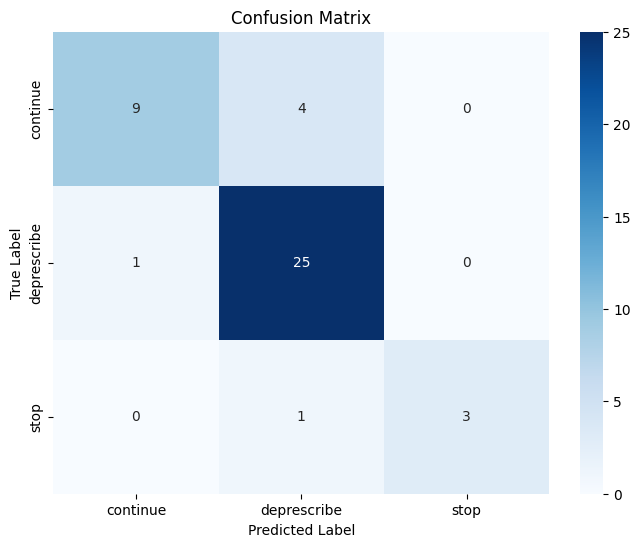

In [39]:
from eval import evaluate_multiclass_classification, get_best_diagnosis_match

y_true = labeled_df['recommendation']
y_pred = labeled_df['ret_recommendation']
class_labels = ['continue', 'deprescribe', 'stop']

# Evaluate the model
metrics = evaluate_multiclass_classification(y_true, y_pred, class_labels)

In [9]:
labeled_df['diagnosis_key'] = labeled_df['diagnosis'].str.split('-').str[0]

In [10]:
for index, row in labeled_df.iterrows():
    matched_diagnosis_key, matched_diagnosis_label = get_best_diagnosis_match(row.ret_reasoning)
    labeled_df.at[index, 'matched_diagnosis_key'] = matched_diagnosis_key
    labeled_df.at[index, 'matched_diagnosis_label'] = matched_diagnosis_label
    

IndexError: list index out of range